In [7]:
import skimage as ski
import matplotlib.pyplot as plt
import numpy as np
import os
import numpy as np
import pandas as pd
from IPython.display import display
from PIL import Image
import subprocess
from torchvision import transforms as T
import torch

# List of image files

In [2]:
def is_pic(inp):
    return inp.lower().endswith(('.jpg','.jpeg','.png','.gif'))

path_to_images = 'images/'
list_images = [img for img in os.listdir(path_to_images) if (os.path.isfile(os.path.join(path_to_images,img)) and is_pic(img))]

print(list_images[:10])
print()
print(len(list_images))

['saint_bernard_188.jpg', 'Ragdoll_164.jpg', 'chihuahua_75.jpg', 'american_bulldog_60.jpg', 'Siamese_9.jpg', 'saint_bernard_122.jpg', 'Bombay_95.jpg', 'Bengal_167.jpg', 'Birman_95.jpg', 'havanese_147.jpg']

7390


In [20]:
with open('annotations_aug/images_list_orig.txt','w') as f:
    for name in list_images:
        f.write('%s\n' %name)

# Alpha matting and transforms

We shall define a method (as a part of a class) to take an image from the image directory, the corresponding trimap image from the respective directory, and then extract the foreground with some border. The convention followed in the trimap images is foreground:1, background:2, border:3. 

In [21]:
class apply_trimap():
    def __init__(self, img):         # img is the file name for the image
        self.img = img
        self.filename = os.path.join('images/',img)
        self.trimap = os.path.join('annotations/trimaps/',os.path.splitext(img)[0]+'.png')
        
        self.pic_array = ski.io.imread(self.filename)/255     # the pixel values are recorded as a float from 0 to 1
        self.trimap_array = ski.io.imread(self.trimap)     
        
    def create_mask(self):
        """to obtain a mask from the trimap to cut out the foreground from the image"""
        self.mask = np.where(self.trimap_array==2,0,self.trimap_array)
        self.mask = np.where(self.mask==1,4,self.mask)
        self.mask = np.where(self.mask==3,2,self.mask)
        #if len(self.pic_array.shape)==3:
        self.mask = np.expand_dims(self.mask/4,-1)      # expand_dims to enable broadcasting, pixel values from 0 to 1 
        return self.mask      
    
    def cutout_pet(self):
        """to obtain the pet image in the foreground against a black background with a narrow border"""
        self.cutout = np.multiply(self.pic_array,self.create_mask())
        return self.cutout

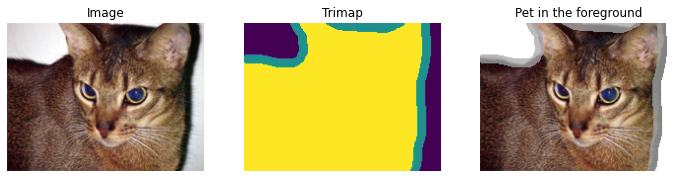

In [22]:
img = 'Abyssinian_5.png'
img_cutout = apply_trimap(img)

demo = plt.figure(figsize=(12,8))
plt.tight_layout

p = demo.add_subplot(1,3,1)
p.imshow(img_cutout.pic_array)
p.set_title('Image')
p.axis('off')

p = demo.add_subplot(1,3,2)
p.imshow(img_cutout.create_mask())
p.set_title('Trimap')
p.axis('off')

p = demo.add_subplot(1,3,3)
p.imshow(img_cutout.cutout_pet())
p.set_title('Pet in the foreground')
p.axis('off')

plt.show()

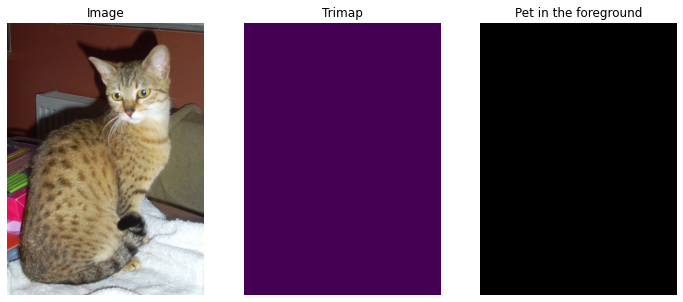

In [23]:
img = 'Egyptian_Mau_196.jpg'
img_cutout = apply_trimap(img)

demo = plt.figure(figsize=(12,8))
plt.tight_layout

p = demo.add_subplot(1,3,1)
p.imshow(img_cutout.pic_array)
p.set_title('Image')
p.axis('off')

p = demo.add_subplot(1,3,2)
p.imshow(img_cutout.create_mask())
p.set_title('Trimap')
p.axis('off')

p = demo.add_subplot(1,3,3)
p.imshow(img_cutout.cutout_pet())
p.set_title('Pet in the foreground')
p.axis('off')

plt.show()

In [24]:
t=img_cutout.trimap_array
np.unique(t)

array([2], dtype=uint8)

Some of the trimap images seem to be wrong, they have a single unique pixel value (background everywhere in the example above), we'll make a list of those so we can avoid using them. Also note that the trimaps directory seems to have many hidden files which we need to avoid anyway.

In [10]:
avoid_trimaps=[]
trimaps_path='annotations/trimaps/'

for trimap in os.listdir(trimaps_path):
    if os.path.isfile(os.path.join(trimaps_path,trimap)) and not trimap.startswith('.') and is_pic(trimap):
        trimap_array = ski.io.imread(os.path.join(trimaps_path,trimap))
        if len(np.unique(trimap_array))==1:
            avoid_trimaps.append(os.path.splitext(trimap)[0])
            
avoid_trimaps

['Egyptian_Mau_129',
 'saint_bernard_78',
 'Egyptian_Mau_167',
 'saint_bernard_15',
 'staffordshire_bull_terrier_22',
 'wheaten_terrier_195',
 'Egyptian_Mau_165',
 'Egyptian_Mau_177',
 'Abyssinian_34',
 'Egyptian_Mau_20',
 'keeshond_7',
 'miniature_pinscher_14',
 'leonberger_18',
 'staffordshire_bull_terrier_2',
 'Egyptian_Mau_191',
 'Egyptian_Mau_162',
 'Persian_259',
 'Egyptian_Mau_196',
 'japanese_chin_199',
 'saint_bernard_108',
 'Egyptian_Mau_145',
 'Egyptian_Mau_139',
 'saint_bernard_60']

In [25]:
with open('annotations_aug/avoid_trimaps.txt','w') as f:
    for name in avoid_trimaps:
        f.write('%s\n' %name)

Now we shall apply the alpha matting procedure (and some other editing) to each image in the dataset (save the trimaps to avoid).

In [11]:
for img in list_images:                                            # shell command to copy all the original images
    subprocess.run(['cp', 'images/'+img, 'images_augmented/'])
    
output_path = 'images_augmented/'

np.random.seed(2)

for img in list_images:
    if os.path.splitext(img)[0] not in avoid_trimaps:
        img_cut = apply_trimap(img)
        img_t = img_cut.cutout_pet()
        img_t = ski.transform.rotate(img_t,angle = np.random.randint(0,360),resize=True)
        if np.random.choice([True,False],p=[0.7,0.3]):
            img_t = np.flip(img_t,np.random.choice([0,1]))
        
        shift_halfrange = np.array(img_t.shape)[:2]/5
        shift_val = [np.random.randint(-s,s) for s in shift_halfrange]
        shift = ski.transform.EuclideanTransform(translation=shift_val)
        img_t = ski.transform.warp(img_t,shift)   # note that warp really implements the inverse shift but it doesn't matter here since we have a random shift chosen from a symmetric range
        

        plt.imsave(os.path.join(output_path,os.path.splitext(img)[0]+'_am.jpg'),img_t)
        
       

# Augmentation with random crop, noise, random perspective, and random rotation

We'll generate some new images by randomly cropping 60% (of the smaller edge) of the image, and add some random noise to it, and also distort the perspective randomly.

Text(0.5, 1.0, 'augmented')

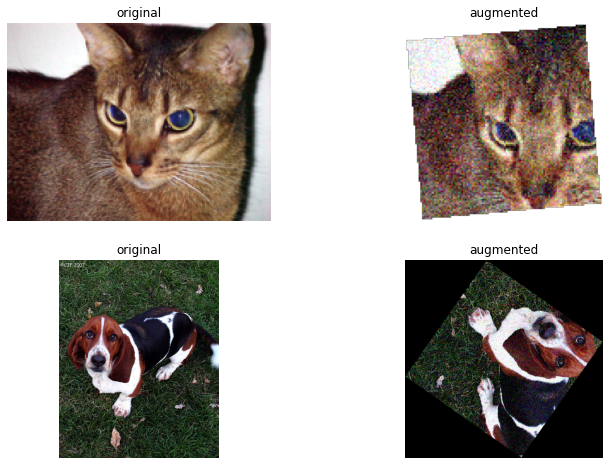

In [52]:
def crop_aug(img):
    img_array = ski.io.imread(img)
    img_array = ski.util.random_noise(img_array, clip = True)
    
    min_side = min(img_array.shape[:2])
    img_tensor = T.ToTensor()(img_array)           # ToTensor does the permutation of the axes from (H,W,C) to (C,H,W) by itself
    img_tensor = T.RandomCrop(int(np.floor(0.7*min_side)), pad_if_needed=True, padding_mode='edge')(img_tensor)
    
    perspective_tr = T.RandomPerspective(distortion_scale=0.6, p=0.8)   # the perspective will be altered randomly with a probability of 0.7
    perspective_tr(img_tensor)
    
    img_tensor = T.RandomRotation(180, expand=True)(img_tensor)
    
    img_array = T.ToPILImage()(img_tensor)   # permutes the axes back (H,W,C), values are in (0,255)
     
    return img_array

seed = 347

sample = plt.figure(figsize=(12,8))
plt.tight_layout

img = 'images/Abyssinian_5.png'
img_crop = crop_aug(img)

o = sample.add_subplot(2,2,1)
o.imshow(ski.io.imread(img))                 # it uses the default colormap to turn it into an RGB image
o.axis('off')
o.set_title('original')

p = sample.add_subplot(2,2,2)
p.imshow(img_crop)
p.axis('off')
p.set_title('augmented')


img = 'images/basset_hound_187.jpg'
img_crop = crop_aug(img)

o = sample.add_subplot(2,2,3)
o.imshow(ski.io.imread(img))                 # it uses the default colormap to turn it into an RGB image
o.axis('off')
o.set_title('original')

p = sample.add_subplot(2,2,4)
p.imshow(img_crop)
p.axis('off')
p.set_title('augmented')

In [ ]:
output_path = 'images_augmented/'

np.random.seed(299)

for img in list_images:
    img_t = crop_aug(img)
    plt.imsave(os.path.join(output_path,os.path.splitext(img)[0]+'_ca.jpg'),img_t)
    
        
       

We also need to resize the images to a uniform size, to avoid warping the images we'll crop out a square (of dimension equal to the shorter edge of the rectangle) from the centre, and then resize them down to a uniform size. We'll also rotate the images with a portrait like shape into a landscape like shape before cropping. We want the network to identify a rotated pet image just the same, so this is good. 

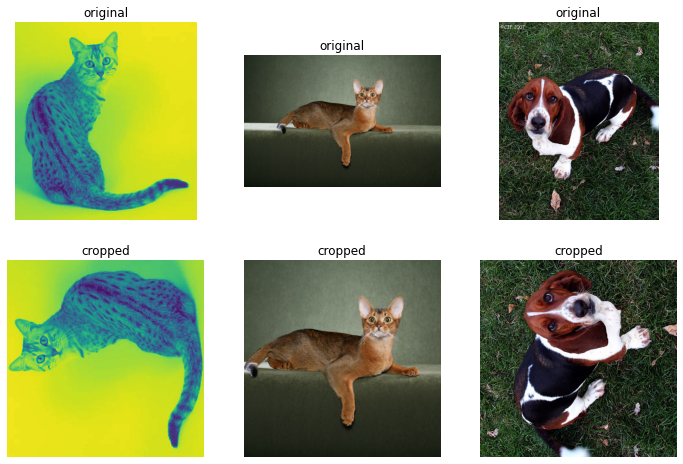

In [12]:
loc = 'images_augmented/'

def crop_sq(file):
    img = ski.io.imread(loc+file)       # os.path.join is a little smarter but this is ok
    if img.shape[0]>img.shape[1]:
        img = np.swapaxes(img,0,1)
    s,l = img.shape[:2] 
            
    centre_crop = np.copy(img.take(indices=range(int(np.floor(l/2-s/2)),int(np.floor(l/2+s/2))),axis=1))    # apparently, some of the images are greayscale so we are keeping it ambiguous if img.shape is (x,y) or (x,y,z)
                                                                                                            # np.copy is used as we sometimes run into problems using imsave on slices later
    return centre_crop



sample = plt.figure(figsize=(12,8))
plt.tight_layout

file='Egyptian_Mau_129.jpg'     # this is a grayscale image in portrait
o_img = ski.io.imread(loc+file)
o = sample.add_subplot(2,3,1)
o.imshow(o_img)                 # it uses the default colormap to turn it into an RGB image
o.axis('off')
o.set_title('original')

crop_img = crop_sq(file)
p = sample.add_subplot(2,3,4)
p.imshow(crop_img)
p.axis('off')
p.set_title('cropped')



file='Abyssinian_1.jpg'     
o_img = ski.io.imread(loc+file)
o = sample.add_subplot(2,3,2)
o.imshow(o_img)
o.axis('off')
o.set_title('original')

crop_img = crop_sq(file)
p = sample.add_subplot(2,3,5)
p.imshow(crop_img)
p.axis('off')
p.set_title('cropped')



file='basset_hound_187.jpg'     
o_img = ski.io.imread(loc+file)
o = sample.add_subplot(2,3,3)
o.imshow(o_img)
o.axis('off')
o.set_title('original')

crop_img = crop_sq(file)
p = sample.add_subplot(2,3,6)
p.imshow(crop_img)
p.axis('off')
p.set_title('cropped')


plt.show()




for file in os.listdir(loc):                               # apply it on all images in the directory
    crop_img = crop_sq(file)
    plt.imsave(os.path.join(loc,file),crop_img)            # imsave is saving any grayscale image as an RGB image with it's default colormap
    

Now we'll resize the images to squares with `side = side_min`. Some of the images are RGBA images, we'll drop the $\alpha$ channel (in the examples I checked the $\alpha$ values were identically 255 anyway).

In [13]:
inp_loc='images_augmented/'
out_loc='img_augmented_processed/'

for img_name in os.listdir(inp_loc):
    img = ski.io.imread(inp_loc+img_name)        
    img = ski.transform.resize(img,(300,300),anti_aliasing=True)       # to avoid aliasing artifacts
    if img.shape[2]==4:
        img = ski.color.rgba2rgb(img)
    
    img_pr = Image.fromarray((img*255).astype(np.uint8))
    img_pr.save(os.path.join(out_loc,img_name))           # using this to save as plt.imsave automatically adds an alpha channel